In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from csaps import csaps
from scipy.signal import butter, freqs

%config InlineBackend.figure_formats = ['svg']

units are always mK, pJ, pW, Ohm, H, muA, V, s, Hz, mm, keV, g, ...

In [2]:
utils_par = {
    'T_bath': 15,  # mK
    'Rs': 0.040,  # Ohm
    'L': 3.5e-7, # H 
    'sample_frequency': 25000,  # Hz
    'record_length': 16384, 
            }
utils_par['t'] = np.arange(0, utils_par['record_length'])/utils_par['sample_frequency']
utils_par['freq'] = np.fft.rfftfreq(utils_par['record_length'], d=1/utils_par['sample_frequency'])

# extract info from pulse shape

In [3]:
path = '../../rltest_data/'

names = ['li1p', 'li1l', 'li2p']

channels = {'li1p': 1, 'li1l': 2, 'li2p': 6,}

sev = {'li1p': np.loadtxt(path + 'Channel_0_SEV_Particle.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_Direct.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_Particle.xy', skiprows=3)}


## pulse shape fit

In [202]:
def pulse_template(t, t0, An, At, tau_n, tau_in, tau_t):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = (An * (np.exp(-(t[cond] - t0) / tau_n) - np.exp(-(t[cond] - t0) / tau_in)) + \
                   At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))
    return pulse

In [203]:
def single_pulse(t, t0, A, tau_rise, tau_decay):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = A * (np.exp(-(t[cond] - t0) / tau_decay) - np.exp(-(t[cond] - t0) / tau_rise))
    return pulse

### Particle pulses

In [204]:
pspars = {'li1p': [-2.74038416, 1.18433165, 1.04116448, 72.05835566, 0.38244691, 9.35751479], 
          'li1l': [-1.330066039435939, 1.0952134272841865, 0.6847593878712344, 17.83502246386849, 0.09396510359613783, 3.6836775281151417], 
          'li2p': [-2.06154929, 1.1372723, 0.94300337, 79.26274212, 0.39666609, 12.05657907]}

In [205]:
pspars_fit = {}
pspars_std = {}
minis = {}

for name in names:
    
    c = cost.LeastSquares(x=sev[name][:,0]*1000, y=sev[name][:,1], yerror=1e-3*np.ones(sev[name].shape[0]), model=pulse_template)
    
    minis[name] = Minuit(c, *pspars[name])

    minis[name].migrad()  # run optimiser
    minis[name].hesse()   # run covariance estimator

    pspars_fit[name] = np.array(minis[name].values)
    pspars_std[name] = np.sqrt(np.diag(list(minis[name].covariance)))

In [206]:
# minis['li1p'].hesse()

In [207]:
# minis['li1p'].hesse()

In [208]:
# minis['li1p'].draw_mncontour("An", "At")

In [209]:
pspars_fit

{'li1p': array([-2.74038416,  1.18433165,  1.04116448, 72.05835566,  0.38244691,
         9.35751479]),
 'li1l': array([-1.33006601,  1.05565334,  0.66002543, 17.83502825,  0.09396504,
         3.68367896]),
 'li2p': array([-2.06154929,  1.1372723 ,  0.94300337, 79.26274212,  0.39666609,
        12.05657907])}

In [210]:
pspars_std

{'li1p': array([0.00022561, 0.00022445, 0.00020167, 0.07450532, 0.00037006,
        0.00394843]),
 'li1l': array([9.85020702e-05, 3.47961430e-04, 5.28301457e-04, 2.03654339e-02,
        1.62348056e-04, 6.09889716e-03]),
 'li2p': array([0.00023489, 0.00018862, 0.00018453, 0.06414667, 0.00037269,
        0.00547734])}

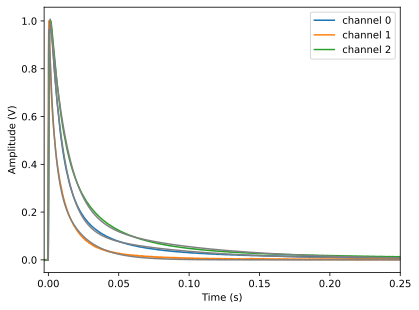

In [211]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], label=f'channel {c}')
    plt.plot(sev[name][:,0] - t0[c], pulse_template(sev[name][:,0]*1000, *pspars_fit[name]), color='grey')
    
plt.xlim(-0.003,0.25)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

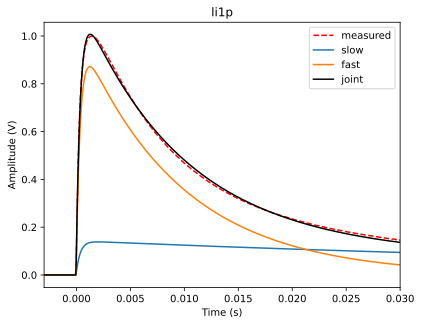

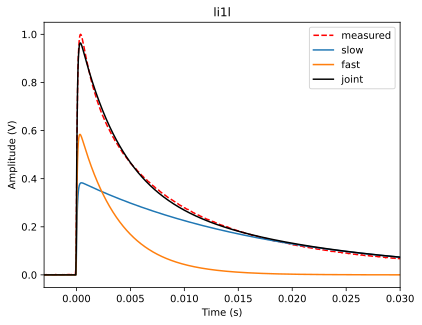

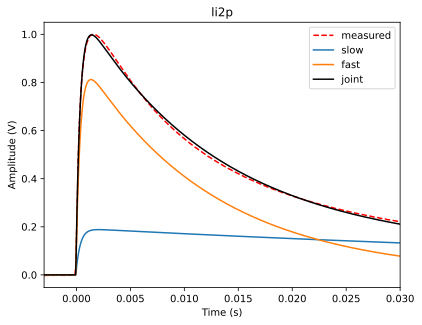

In [212]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    fast_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0], 
                          pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][5])
    slow_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0],
                          pspars_fit[name][1] - pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][3])
    plt.plot(sev[name][:,0] - t0[c], slow_pulse, label='slow')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse, label='fast')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse + slow_pulse, 
             color='black', label='joint')
    
    plt.xlim(-0.003,0.03)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

In [213]:
Afast = {}
Aslow = {}
tau_rise = {}
tau_fast = {}
tau_slow = {}

for name in names:
    Afast[name] = pspars_fit[name][2]
    Aslow[name] = pspars_fit[name][1] - pspars_fit[name][2]
    tau_rise[name] = pspars_fit[name][4]*1e-3  # s
    tau_fast[name] = pspars_fit[name][5]*1e-3  # s
    tau_slow[name] = pspars_fit[name][3]*1e-3  # s

In [214]:
Afast

{'li1p': 1.04116448, 'li1l': 0.6600254261826252, 'li2p': 0.94300337}

In [215]:
Aslow

{'li1p': 0.14316717000000012, 'li1l': 0.3956279154612071, 'li2p': 0.19426893}

In [216]:
tau_rise

{'li1p': 0.00038244691, 'li1l': 9.396504105641667e-05, 'li2p': 0.00039666609}

In [217]:
tau_fast

{'li1p': 0.00935751479, 'li1l': 0.003683678964822836, 'li2p': 0.01205657907}

In [218]:
tau_slow

{'li1p': 0.07205835566,
 'li1l': 0.017835028251184513,
 'li2p': 0.07926274212000001}

### Test pulses

In [219]:
sev_tp = {'li1p': np.loadtxt(path + 'Channel_0_SEV_TP.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_TP.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_TP.xy', skiprows=3)}


In [220]:
pspars_fit_tp = {}
pspars_std_tp = {}
minis_tp = {}

for name in names:
    
    c = cost.LeastSquares(x=sev_tp[name][:,0]*1000, y=sev_tp[name][:,1], yerror=1e-3*np.ones(sev[name].shape[0]), model=pulse_template)
    
    if name != 'li1l':
        tau_rise_ = 4.97
    else:
        tau_rise_ = 2.98
    tau_t_ = tau_slow[name]
    tau_in_ = tau_fast[name]
    minis_tp[name] = Minuit(c, t0=0., An=2., At=.5, tau_n=tau_rise_, tau_in=tau_in_, tau_t=tau_t_)
    minis_tp[name].fixed["t0"] = True
    # minis_tp[name].fixed["tau_n"] = True
    # minis_tp[name].fixed["tau_t"] = True

    minis_tp[name].migrad()  # run optimiser
    minis_tp[name].hesse()   # run covariance estimator

    pspars_fit_tp[name] = np.array(minis_tp[name].values)
    pspars_std_tp[name] = np.sqrt(np.diag(list(minis_tp[name].covariance)))
    

/var/folders/0y/_zyrlyfn1412ysy20pvh2r8c0000gn/T/ipykernel_66502/2353356893.py:6: RuntimeWarning: overflow encountered in exp
  At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))


In [221]:
pspars_fit_tp

{'li1p': array([ 0.        , 15.97228489, 14.56366181, 31.86684597,  2.22290811,
         1.98929387]),
 'li1l': array([ 0.        , 12.12228735, 10.47515972, 12.86845405,  1.22411889,
         1.03215618]),
 'li2p': array([ 0.        , 18.05327421, 16.73713331, 40.57423761,  2.33886325,
         2.13157973])}

In [222]:
pspars_std_tp

{'li1p': array([0.        , 0.0006766 , 0.00067602, 0.00358788, 0.0003295 ,
        0.00032077]),
 'li1l': array([0.        , 0.0010828 , 0.00108131, 0.00203153, 0.00028562,
        0.00026991]),
 'li2p': array([0.        , 0.00059624, 0.00059583, 0.00407827, 0.0003159 ,
        0.00031122])}

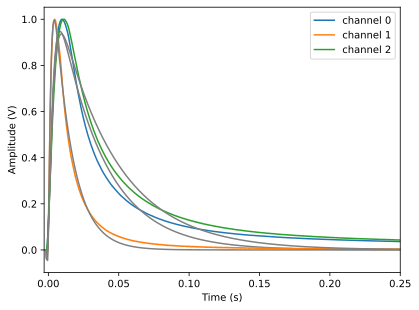

In [223]:
t0 = [0.00164357738, 0.00083735524, 0.00177721804]

for c,name in enumerate(names):
    plt.plot(sev_tp[name][:,0] - t0[c], sev_tp[name][:,1], label=f'channel {c}')
    plt.plot(sev_tp[name][:,0] - t0[c], pulse_template(sev_tp[name][:,0]*1000, *pspars_fit_tp[name]), color='grey')
    
plt.xlim(-0.003,0.25)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [224]:
pspars_fit_tp_single = {}
pspars_std_tp_single = {}
minis_tp_single = {}

for name in names:
    
    c = cost.LeastSquares(x=sev_tp[name][:,0]*1000, y=sev_tp[name][:,1], yerror=1e-3*np.ones(sev[name].shape[0]), model=single_pulse)
    
    if name != 'li1l':
        tau_rise_ = 4.97
    else:
        tau_rise_ = 2.98
    minis_tp_single[name] = Minuit(c, t0=0., A=1., tau_rise=tau_rise_, tau_decay=70)
    minis_tp_single[name].fixed["t0"] = True
    minis_tp_single[name].fixed["tau_rise"] = True

    minis_tp_single[name].migrad()  # run optimiser
    minis_tp_single[name].hesse()   # run covariance estimator

    pspars_fit_tp_single[name] = np.array(minis_tp_single[name].values)
    pspars_std_tp_single[name] = np.sqrt(np.diag(list(minis_tp_single[name].covariance)))

In [225]:
pspars_fit_tp_single

{'li1p': array([ 0.        ,  1.49167618,  4.97      , 30.84026598]),
 'li1l': array([ 0.        ,  1.95907262,  2.98      , 11.74423323]),
 'li2p': array([ 0.        ,  1.33998561,  4.97      , 40.31573995])}

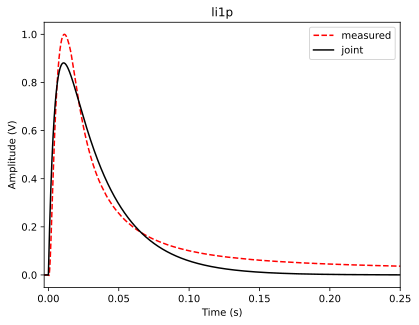

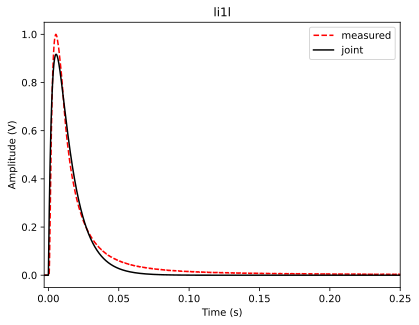

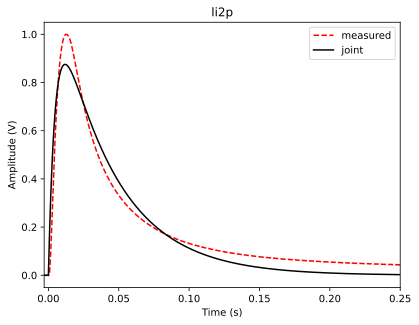

In [226]:
for c,name in enumerate(names):
    plt.plot(sev_tp[name][:,0] - pspars_fit_tp[name][0]/1000, sev_tp[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    pulse = single_pulse(sev_tp[name][:,0]*1000, *pspars_fit_tp_single[name])
    plt.plot(sev_tp[name][:,0], pulse, color='black', label='joint')
    
    plt.xlim(-0.003,0.25)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

In [227]:
Afast_tp = {}
Aslow_tp = {}
tau_rise_tp = {}
tau_fast_tp = {}
tau_slow_tp = {}

for name in names:
    if name != 'li1l':  # calorimetric
        Afast_tp[name] = pspars_fit_tp[name][2]
        Aslow_tp[name] = pspars_fit_tp[name][1] - pspars_fit_tp[name][2] 
        tau_rise_tp[name] = pspars_fit_tp[name][4]*1e-3  # s
        tau_fast_tp[name] = pspars_fit_tp[name][5]*1e-3  # s
        tau_slow_tp[name] = pspars_fit_tp[name][3]*1e-3  # s
    else:  # bolometric
        Afast_tp[name] = - pspars_fit_tp[name][1]   
        Aslow_tp[name] = pspars_fit_tp[name][2] 
        tau_rise_tp[name] = pspars_fit_tp[name][3]*1e-3  # s
        tau_fast_tp[name] = pspars_fit_tp[name][4]*1e-3  # s
        tau_slow_tp[name] = pspars_fit_tp[name][5]*1e-3  # s

In [228]:
Afast_tp

{'li1p': 14.56366181488764,
 'li1l': -12.12228734576782,
 'li2p': 16.73713331209616}

In [229]:
Aslow_tp

{'li1p': 1.4086230770003105,
 'li1l': 10.475159722089357,
 'li2p': 1.3161408958426613}

In [230]:
tau_rise_tp

{'li1p': 0.002222908113599202,
 'li1l': 0.012868454045687611,
 'li2p': 0.0023388632502691644}

In [231]:
tau_fast_tp

{'li1p': 0.0019892938738028895,
 'li1l': 0.0012241188899763068,
 'li2p': 0.0021315797336723032}

In [232]:
tau_slow_tp

{'li1p': 0.03186684597314096,
 'li1l': 0.0010321561779201068,
 'li2p': 0.040574237612626074}

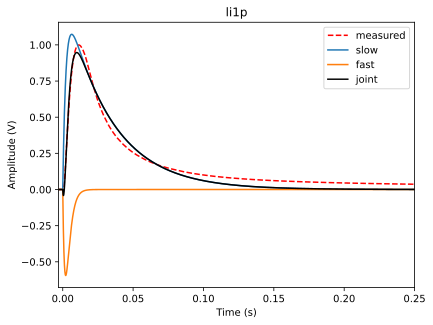

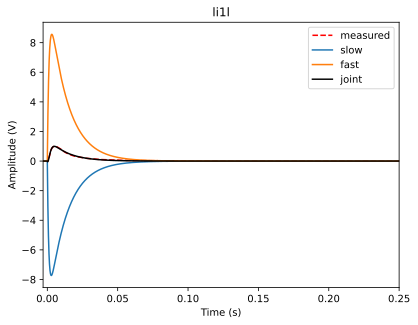

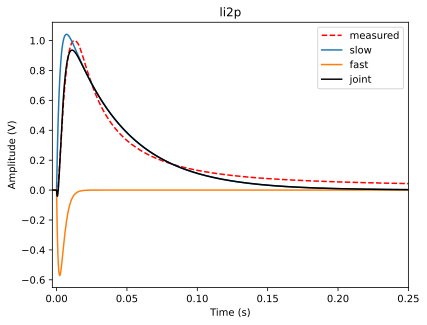

In [233]:
for c,name in enumerate(names):
    plt.plot(sev_tp[name][:,0] - pspars_fit_tp[name][0]/1000, sev_tp[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    fast_pulse = single_pulse(sev_tp[name][:,0]*1000, 
                          0., 
                          Afast_tp[name],
                          tau_rise_tp[name]*1e3,
                          tau_fast_tp[name]*1e3)
    slow_pulse = single_pulse(sev_tp[name][:,0]*1000, 
                          0.,
                          Aslow_tp[name],
                          tau_rise_tp[name]*1e3,
                          tau_slow_tp[name]*1e3)
    plt.plot(sev_tp[name][:,0], slow_pulse, label='slow')
    plt.plot(sev_tp[name][:,0], fast_pulse, label='fast')
    plt.plot(sev_tp[name][:,0], fast_pulse + slow_pulse, 
             color='black', label='joint')
    
    plt.xlim(-0.003,0.25)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

## transition curve

In [36]:
tes_rt0 = {'li1p': 0.110, 'li1l': 0.115, 'li2p': 0.100, }  # Ohm
bias = {'li1p': 0.28 * 17.86, 'li1l': 0.084 * 17.86, 'li2p': 0.336 * 17.86,}  # muA

In [37]:
bias

{'li1p': 5.0008, 'li1l': 1.50024, 'li2p': 6.00096}

In [272]:
tes_tc = {'li1p': 30.8, 'li1l': 23, 'li2p': 29.3, }  # mK
tes_width = {'li1p': 1, 'li1l': 1.7, 'li2p': 1.5, }  # mK

# self_heating_narrowing = {'li1p': 0.35,  # 0.8, 
#                           'li1l': 0.75, 
#                           'li2p': 0.35,  # 1.2, 
#                          }

self_heating_narrowing = {'li1p': 0.24,  # 0.8, 
                          'li1l': 0.27, 
                          'li2p': 0.13,  # 1.2, 
                         }


In [273]:
self_heating_narrowing

{'li1p': 0.24, 'li1l': 0.27, 'li2p': 0.13}

### estimate curve with splines

In [274]:
# Attention - this curve is actually taken with 1 muA!

transition_curves = np.loadtxt(path + 'rl_tests.xy', skiprows=5)[2600:10000]

transition_curves = {'li1p': transition_curves[:,[0,1]], 
                     'li1l': transition_curves[:,[0,2]], 
                     'li2p': transition_curves[:,[0,3]]}

In [275]:
def temp_trafo(x, limits, stretch, shift):
    return (x - limits[1])*stretch + limits[1] + shift

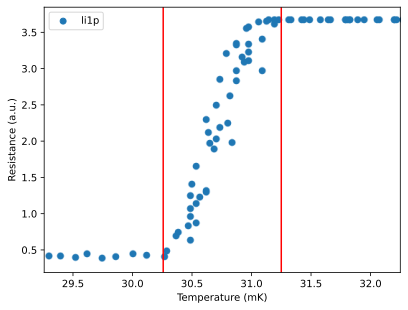

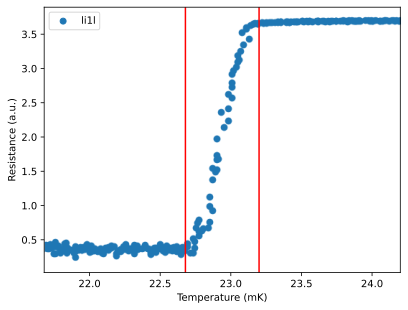

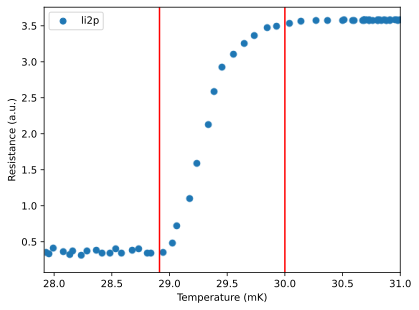

In [276]:
limits = {'li1p': np.array([30.45, 31.25]), 
          'li1l': np.array([22.75, 23.2]), 
          'li2p': np.array([29, 30.]),}
stretch = {}
shift = {}

for name in names:
    stretch[name] = (tes_width[name] + self_heating_narrowing[name])/tes_width[name] 
    shift[name] = 0.

for name in names:
    plt.scatter(temp_trafo(transition_curves[name][:,0], limits[name], stretch[name], shift[name]), 
                transition_curves[name][:,1], label=name, rasterized=True)
    for i in range(2):
        plt.axvline(temp_trafo(limits[name][i], limits[name], stretch[name], shift[name]), color='red')
    plt.ylabel('Resistance (a.u.)')
    plt.xlabel('Temperature (mK)')
    plt.xlim((temp_trafo(limits[name][0], limits[name], stretch[name], shift[name]) - 1, temp_trafo(limits[name][1], limits[name], stretch[name], shift[name]) + 1))
    plt.legend()
    plt.show()

In [277]:
for name in names:
    transition_curves[name][:,0] = temp_trafo(transition_curves[name][:,0], limits[name], stretch[name], shift[name])
    limits[name] = temp_trafo(limits[name], limits[name], stretch[name], shift[name])

In [278]:
transition_curves_sorted = {}
transition_curves_cleaned = {}
temp_grids = {'li1p': np.linspace(25,35, 1000),
              'li1l': np.linspace(18,28, 1000),
              'li2p': np.linspace(20,35, 1000),}
transition_curve_splines = {}
transition_curve_derivative_splines = {}
xlims = {}
for name in names:
    xlims[name] = (limits[name][0] - 1, limits[name][1] + 1)

for name in names:
    transition_curves_sorted[name] = np.sort(transition_curves[name], axis=0)

    transition_curves_cleaned[name] = []
    for v in np.unique(transition_curves_sorted[name][:,0]):
        transition_curves_cleaned[name].append(np.mean(
            transition_curves_sorted[name][transition_curves_sorted[name][:,0] == v], axis=0))
    transition_curves_cleaned[name] = np.array(transition_curves_cleaned[name])
    
    transition_curves[name][:,1] = transition_curves[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    transition_curves_cleaned[name][:,1] = transition_curves_cleaned[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    
    transition_curve_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           transition_curves_cleaned[name][:,1], 
                                           temp_grids[name], smooth=0.99999)
    
    transition_curve_derivative_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           np.gradient(transition_curves_cleaned[name][:,1], 
                                                       transition_curves_cleaned[name][:,0]), 
                                           temp_grids[name], smooth=0.9999)

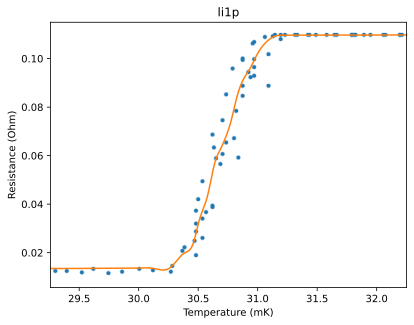

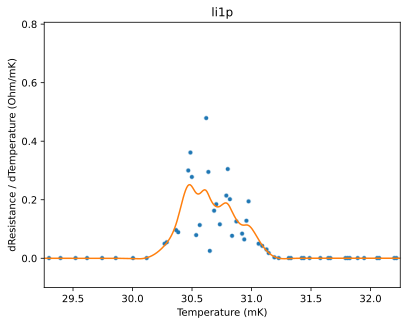

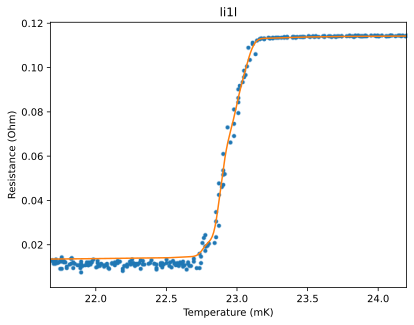

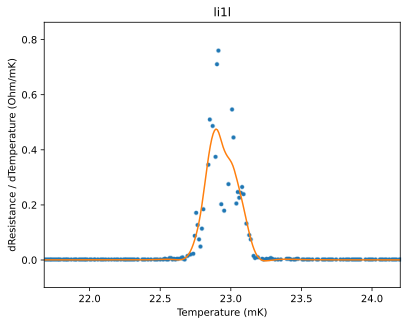

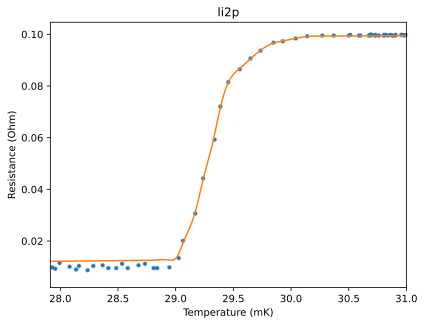

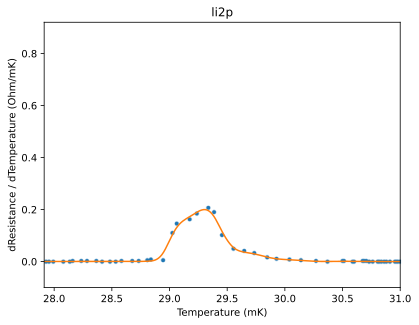

In [279]:
for name in names:
    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=10, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.title(name)
    plt.xlim(xlims[name])
    plt.show()
    
    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=10, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1/stretch[name])
    plt.show()

## pulse heights in temperature

SQUID sensitivity * 100

U / phi0 8.65

I / phi0 0.15

In [280]:
# for this we need the transition curve and the OP at the point where A_fast was measured
# scale the transition curve to the bias current and get derivative at DAC
# get V/phi_0 from Heater bias client: Phi-0 [Volt / Phi-0]: 8.65
# the input coil sensitivity is then 0.15 muA/phi_0
# therefore 8.65 V PH = 0.15 muA PH * der sensitivity range (zehnerpotenz)
# sensitivity range get from squid client - it is * 10

v_to_muA = 0.15 / 8.65 * 10  # muA/V
v_to_muA_op = 0.15 / 8.65 * 10

In [281]:
v_to_muA

0.17341040462427743

In [282]:
# bias currents were: Li1P 2.8, Li1L 0.84, Li2P 3.0
# V_sets were: Li1P 1.55, Li1L 0.287, Li2P 2.5
# attention! highest pulses were: Li1P 3.35, Li1L 2.24, Li2P 9.28

# v_sets = {'li1p': 1.55, 'li1l': 0.287, 'li2p': 2.5,} 
v_sets = {'li1p': 3.35, 'li1l': 2.24, 'li2p': 9.28,} 
Vph_iron = {'li1p': 0.37, 'li1l': 3.3, 'li2p': 0.523}

In [283]:
# and we need A_fast in term of temperature

# I_squid_op = {}
V_op = {}
R_op = {}

for name in names:

    # I_squid_op[name] = v_to_muA * v_sets[name]
    V_op[name] = bias[name] / v_to_muA_op / (utils_par['Rs'] / tes_rt0[name] + 1) - v_sets[name]
    R_op[name] = utils_par['Rs'] / (bias[name] / v_to_muA_op / V_op[name] - 1)

In [284]:
V_op

{'li1p': 17.797827555555557,
 'li1l': 4.17876877419355,
 'li2p': 15.43824000000001}

In [285]:
R_op

{'li1p': 0.06448418672455546,
 'li1l': 0.03737203907085551,
 'li2p': 0.03221787778516074}

In [286]:
# eval derivative of transition curve at all OPs

# T_op = {'li1p': temp_trafo(30.91, limits['li1p'], stretch['li1p'], shift['li1p']), 
#         'li1l': temp_trafo(23.07, limits['li1l'], stretch['li1l'], shift['li1l']), 
#         'li2p': temp_trafo(29.435, limits['li2p'], stretch['li2p'], shift['li2p']),}
T_op = {'li1p': temp_trafo(30.8, limits['li1p'], stretch['li1p'], shift['li1p']), 
        'li1l': temp_trafo(22.92, limits['li1l'], stretch['li1l'], shift['li1l']), 
        'li2p': temp_trafo(29.25, limits['li2p'], stretch['li2p'], shift['li2p']),}
# dRdT_op = {'li1p': 0.205/2 / stretch['li1p'], 
#            'li1l': 0.32 / stretch['li1l'], 
#            'li2p': 0.198/2.5 / stretch['li2p']}
dRdT_op = {'li1p': 0.15 / stretch['li1p'], 
           'li1l': 0.45 / stretch['li1l'], 
           'li2p': 0.15 / stretch['li2p']}  # 0.198

In [287]:
T_op

{'li1p': 30.692, 'li1l': 22.87552941176471, 'li2p': 29.185}

In [288]:
# linear approx:

dRdT_op_linear = {}

for name in names:
    dRdT_op_linear[name] =  tes_rt0[name]/(limits[name][1] - limits[name][0])/stretch[name] 

In [289]:
dRdT_op_linear

{'li1p': 0.08942507804370439,
 'li1l': 0.19030522702351466,
 'li2p': 0.08468515939628897}

In [290]:
# ATTENTION! Here we need to make a choice. Trust the OP or linear ?

# dRdT_op = dRdT_op_linear

# for name in names:
#     T_op[name] -= 2

In [291]:
# linearize the transition curve:
# around the OP it is roughly R(T + deltaT) = R_op + dRdT_op * deltaT
# we invert to deltaT = (R(T + deltaT) - R_op) / dRdT_op
# but this is also deltaT = (R(Vop + deltaVph) - R_op) / dRdT_op if we can linearize the R function as well

# linearize the function for the resistance:
# R(Vop + deltaVph) = Rref / (Ib / u / (Vop + deltaVph) - 1), with u = (I/phi_0) * (phi0/U) * sensitivitySQUID 
# the derivative for V at the OP is = u * Rref * Ib / (Ib - u * V_op) ** 2
# around the OP it is threfore linearized to R(Vop + deltaVph) = Rref / (Ib / u / Vop - 1) + u * Rref * Ib / (Ib - u * V_op) ** 2 * deltaVph

R_iron = {}  # resistance increase for iron events
Tph_iron = {}

for name in names:
    
    R_iron[name] = utils_par['Rs'] / (bias[name] / v_to_muA_op / V_op[name] - 1) + v_to_muA_op * utils_par['Rs'] * bias[name] / (bias[name] - v_to_muA_op * V_op[name]) ** 2 * Vph_iron[name] 
    Tph_iron[name] = (R_iron[name] - R_op[name]) / dRdT_op[name]
    

In [292]:
R_iron

{'li1p': 0.06798588346342287,
 'li1l': 0.09445893701383369,
 'li2p': 0.03418841917407857}

In [293]:
Tph_iron

{'li1p': 0.028947359707970594,
 'li1l': 0.1470080901276693,
 'li2p': 0.014275477617493596}

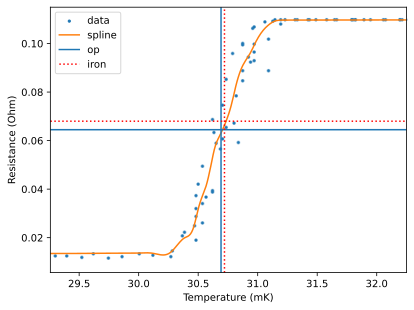

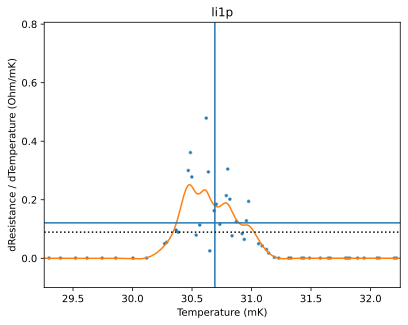

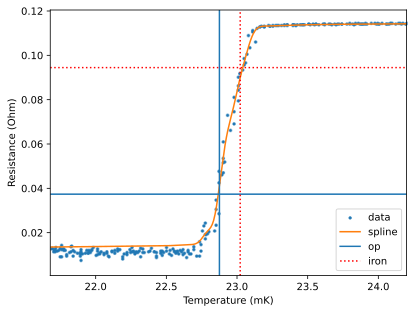

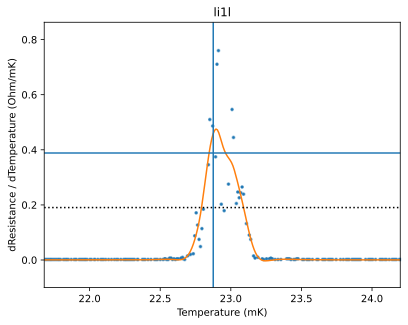

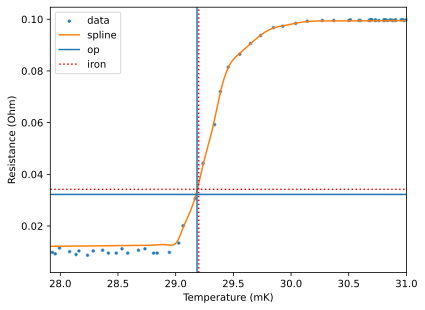

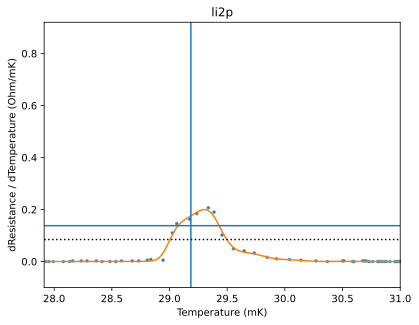

In [294]:
# only plot

for name in names:

    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True, label='data')
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1', label='spline')
    plt.axhline(R_op[name], label='op')
    plt.axvline(T_op[name])
    plt.axhline(R_iron[name], color='red', linestyle='dotted', label='iron')
    plt.axvline(T_op[name] + Tph_iron[name], color='red', linestyle='dotted')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.xlim(xlims[name])
    plt.legend()
    plt.show()

    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.axvline(T_op[name])
    plt.axhline(dRdT_op[name], label='op')
    plt.axhline(dRdT_op_linear[name], color='black', linestyle='dotted', label='linear approx')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1 / stretch[name])
    plt.show()


### cross check self heating effect with transition curve upwards taken

In [295]:
transition_curves_raw = np.loadtxt(path + 'rl_tests.xy', skiprows=5)

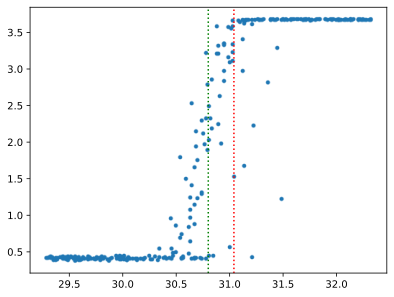

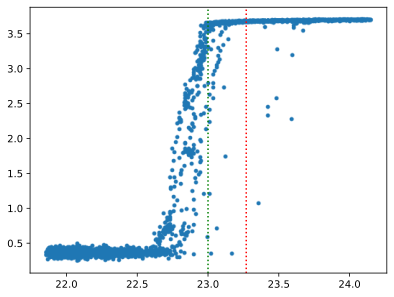

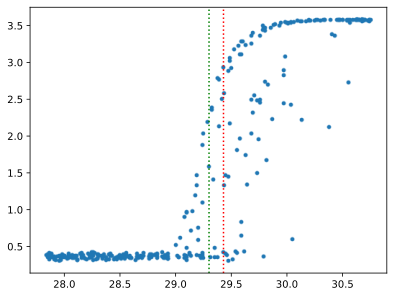

In [296]:
for i, name in enumerate(names):
    cut = transition_curves_raw[:, 0] < tes_tc[name]*1.05
    cut = np.logical_and(cut, transition_curves_raw[:, 0] > tes_tc[name]*0.95)

    plt.scatter(transition_curves_raw[cut, 0], 
                transition_curves_raw[cut, 1+i], rasterized=True, s=10)
    plt.axvline(tes_tc[name], color='green', linestyle='dotted')
    plt.axvline(tes_tc[name] + self_heating_narrowing[name], color='red', linestyle='dotted')
    plt.show()

# calc detector properties

In [297]:
# below are constants of nature

kB = 1.380649e-17  # mm ^ 2 * g / s^2 / mK     # nJ / mK
na = 6.02214076e23  # number of items per mole
h_const = 6.62607015e-34  # kg * m^2 / s
e_charge = 1.60217663e-19  # coulombs

In [298]:
density = {'W': 0.01935, 'Au': 0.01932, 'Al': 0.002702, 'CaWO4': 0.00606, 'Si': 0.00233, 'Al2O3': 0.00398, 'LiAlO2': 0.002615, 'Cu': 0.0089, }  # g/mm^3
molar_mass = {'W': 183.84, 'Au': 196.96655, 'Al': 26.981538, 'CaWO4': 287.9156, 'Si': 28.0855, 'Al2O3': 101.961276, 'LiAlO2': 65.92, 'Cu': 63.546, }  # g/mole

energy_gap = {'CaWO4': 5.2e-3, 'Si': 1.12e-3, 'Al203': 8.3e-3, 'LiAlO2': 4.59, 'Cu': 0.0, }  # keV
sommerfeld_constant = {'W': 1.01e3, 'Au': 0.729e3, 'Al': 1.356e3, 'Cu': 0.7e3, }  # pJ / mol / mK^2 ; gold value is from Florians book
fermi_temp = {'W': 27_000_000, 'Au': 63_900_000, 'Al': 134_900_000, 'Cu': 8_160_000, }  # mK
electron_phonon_coupling = {'W': 2.1e-4}  # pW / mK^6 / mm^3 - multiply with T^5 (mK) and volume (mm^3)
thermal_conductivity = {'Au': 17.1e3}  # pW / mK^2 / mm - multiply with temperature (mK) and cross section (mm^2), divide by length (mm) 


In [299]:
# speed of sound 
K_mod = {'LiAlO2': 94, 'Al2O3': 232, 'Si': 83, 'Cu': 39,}  # bulk modulus, GPa
G_mod = {'LiAlO2': 53, 'Al2O3': 149, 'Si': 63, 'Cu': 53,}   # shear modulus, GPa
s_long = {}
s_trans = {}
s_eff = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:

    s_long[name] = np.sqrt( (K_mod[name] + 4/3*G_mod[name]) / density[name] * 1e3 ) # sqrt( 10**6 / s ** 2 / mm * mole )
    s_trans[name] = np.sqrt( G_mod[name] / density[name] * 1e3)  # sqrt( 10**6 / s ** 2 / mm * mole )
    s_eff[name] = ((1/3) * s_long[name] ** (-3) + (2/3) * s_trans[name] ** (-3) ) ** ( - 1 / 3)  # m/s
    

In [300]:
# atomic density lithium aluminate
n_atom = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    n_atom[name] = density[name] / (molar_mass[name] / na) * 1e9  # 1/m^3
    print(name, n_atom[name])

LiAlO2 2.388940850637136e+28
Al2O3 2.3507081477481704e+28
Si 4.996025696818643e+28
Cu 8.43437081232493e+28


In [301]:
# Debye freqency is ω^3_D=6π^2nc^3. (https://lampx.tugraz.at/~hadley/ss1/phonons/table/dosdebye.html)

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_eff[name] ** 3) ** (1/3)  # rad / sec
    # deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_long[name] ** 3) ** (1/3)  # rad / sec
    print('deb freq', name, deb_freq*1e-12/2/np.pi, 'in THz')
    # print(name, deb_freq * h_const / kB, 'in mK')
    td = deb_freq/2/np.pi * h_const / kB * 1e9 # mK
    print('deb temp', name, td, 'in mK')
    
# debye model phonon heat resistance
# http://lampx.tugraz.at/~hadley/ss2/transport/phonon_Boltzmann.php

deb freq LiAlO2 8.943137886280796 in THz
deb temp LiAlO2 429202.92554892146 in mK
deb freq Al2O3 12.051032854168913 in THz
deb temp Al2O3 578358.3595227894 in mK
deb freq Si 13.111905093419978 in THz
deb temp Si 629272.1969823111 in mK
deb freq Cu 7.216316271648248 in THz
deb temp Cu 346328.5588192781 in mK


In [302]:
# below are constants of the materials

debye_frequency = {'CaWO4': 4.7, 'Si': 13.5, 'Al2O3': 21.7,  # from pantic thesis , THz
                   'LiAlO2': 8.943, 'Cu': 7.22, }  # calc above
                # mK  # debye_temp * h_const / kB
debye_temp = {'W': 383_000, 'Au': 162_000, 'Al': 428_000, 'CaWO4': 228_000, 'Si': 648_000, 'Al2O3': 1_041_000,  # from pantic thesis 
              'LiAlO2': 429_202, 'Cu': 346_328, }  # mK  # calc above


In [303]:
abs_material = {'li1p': 'LiAlO2', 'li1l': 'Al2O3', 'li2p': 'LiAlO2', }
abs_volume = {'li1p': 4000, 'li1l': 200, 'li2p': 4000, }  # mm^3
abs_surface = {'li1p': 1600, 'li1l': 840, 'li2p': 1600, }  # mm^2

# phonon size M, light size S 
tes_thickness = {'li1p': 0.0002, 'li1l': 0.0002, 'li2p': 0.0002, }  # mm
tes_surface = {'li1p': 2.04, 'li1l': 1.02, 'li2p': 2.04, }  # mm^2 
pc_surface = {'li1p': 16.53, 'li1l': 7.6, 'li2p': 16.53, }  # mm^2
thermal_link_width = {'li1p': 0.040, 'li1l': 0.040, 'li2p': 0.040, }  # mm
thermal_link_thickness = {'li1p': 0.000080, 'li1l': 0.000080, 'li2p': 0.000080, }  # mm
thermal_link_length = {'li1p': 0.61, 'li1l': 1., 'li2p': 0.61, }  # mm


## copper holders

In [304]:
tau_holder = {'li1p': 200, 'li1l': 100, 'li2p': 200,}
volume_holder = dict([(name, 400) for name in names])

C_holder = {}

for name in names:
    mat = 'Cu'
    n_mol = volume_holder[name] * density[mat] / molar_mass[mat] 
    C_holder[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3

G_holder = dict([(name, C_holder[name]/tau_holder[name]) for name in names])

In [305]:
C_holder

{'li1p': 0.0757913165226472,
 'li1l': 0.03138031825188327,
 'li2p': 0.06516628678527657}

In [306]:
G_holder

{'li1p': 0.000378956582613236,
 'li1l': 0.0003138031825188327,
 'li2p': 0.00032583143392638284}

## heat capacity absorber phonons and TES electrons

In [307]:
# values from literature

Ref: sisti (2001)

|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Toperating (mK) |  19.3 |  12.3 |  16.7  | 10 | 
 | Ca (pJ/mK)  | 0.1595 |  0.041.7 |  0.103  | 0.0221 | 

 **Thermometer** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermometer Area (mm^2)  | 117  | 72  | 72 | 72 | 
 | Thermometer Thickness (mm) |  0.000210  | 0.000130  | 0.000180 |  0.000180 | 
 | Thermometer Rth (n.c.) (Ohm) |  0.193 |  0.160 |  0.210 |  0.290 | 
 | Thermometer Roperating (Ohm)  | 0.161  | 0.070  | 0.125 |  0.095 | 
 | Thermometer Ce (pJ/mK)  | 0.0677 |  0.022  | 0.036 |  0.0269 | 


In [308]:
print('sisti had this strength of e-ph coupling:', 16.7**5*72*0.000180*2.1e-4)
print('sisti had this strength of thermal link:', 22.4)

sisti had this strength of e-ph coupling: 3.5351402802801117
sisti had this strength of thermal link: 22.4


In [309]:
Cph_mm3 = {}  # pJ / mK / mm^3
Ce_mm3 = {}  # pJ / mK / mm^3
Cph = {}  # pJ / mK
Ce = {}  # pJ / mK
Ce_normal = {}  # pJ / mK
Cph_tes = {}  # pJ / mK  # we ignore this in the end!

for name in names:
    mat = abs_material[name]
    n_mol_mm3 = density[mat] / molar_mass[mat] 
    Cph_mm3[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol_mm3 * 1e3
    
    n_mol = abs_volume[name] * density[mat] / molar_mass[mat] 
    Cph[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3
    
    n_mol_mm3 = density['W'] / molar_mass['W']
    Ce_mm3[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol_mm3 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W']
    Ce_normal[name] = sommerfeld_constant['W'] * T_op[name] * n_mol 
    Ce[name] = Ce_normal[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name])
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W'] 
    Cph_tes[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp['W']) ** 3 * n_mol * 1e3

    

In [310]:
Cph  # same OOM than sisti

{'li1p': 0.11278458890356916,
 'li1l': 0.00016102154757156599,
 'li2p': 0.0969735479295089}

In [311]:
Ce_normal

{'li1p': 0.0013312134117493474,
 'li1l': 0.0004960936327676242,
 'li2p': 0.001265849844321149}

In [312]:
Ce  # factor 20 smaller than sisti (expected)

{'li1p': 0.002118899805775708,
 'li1l': 0.0009749662772250673,
 'li2p': 0.0024928182849249317}

In [313]:
Cph_tes  # ignored

{'li1p': 4.29561435803499e-08,
 'li1l': 8.89269060276967e-09,
 'li2p': 3.6934209618989035e-08}

## Couplings

### calculate values from literature 

Ref: sisti (2001)

**Thermal coupling** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermal coupling No. of Au wires  | 2 |  1 |  2 |  2 | 
 | Thermal coupling Diameter (mm)  | 0.025 |  0.025 |  0.025 |  0.025 | 
 | Thermal coupling Length (mm)  | 20 |  30  | 25  | 25 | 
 | Thermal coupling GAu (pW/mK) |  18.2 |  3.8 |  22.4 |  13.4 | 


In [314]:
# pantic

In [315]:
eph_coupling_calc = {}  # pW/mK
thermal_link_calc = {}  # pW/mK

for name in names:
    tes_vol = tes_surface[name] * tes_thickness[name] 
    eph_coupling_calc[name] = electron_phonon_coupling['W'] * T_op[name] ** 5 * tes_vol
    thermal_link_calc[name] = thermal_conductivity['Au'] * (T_op[name] + utils_par['T_bath'])/2 * thermal_link_width[name] * thermal_link_thickness[name] / thermal_link_length[name]
    

In [316]:
eph_coupling_calc  # do not match

{'li1p': 2.333487105960385,
 'li1l': 0.26835224391983203,
 'li2p': 1.8141698541846067}

In [317]:
thermal_link_calc  # do not match

{'li1p': 2.0493985573770495,
 'li1l': 1.0362744847058827,
 'li2p': 1.9818059016393446}

### get values from data

In [318]:
tau_film = {}
tau_crystal = {}
epsilon = {}

energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218

for name in names:
    epsilon[name] = + Afast[name] * Tph_iron[name] * Ce[name] / energy
    tau_crystal[name] = + tau_rise[name] / epsilon[name]
    tau_film[name] = tau_rise[name] / (1 - epsilon[name])
    epsilon[name] = tau_film[name] / (tau_film[name] + tau_crystal[name])

In [319]:
epsilon

{'li1p': 0.06692758218603517,
 'li1l': 0.09914205337862575,
 'li2p': 0.03516907350398362}

\begin{equation}
\begin{array}{l}C_{e} \frac{d T_{e}}{d t}+\left(T_{e}-T_{a}\right) G_{e a}+\left(T_{e}-T_{b}\right) G_{e b}=P_{e}(t) \\ C_{a} \frac{d T_{a}}{d t}+\left(T_{a}-T_{e}\right) G_{e a}+\left(T_{a}-T_{b}\right) G_{a b}=P_{a}(t)\end{array}
\end{equation}

\begin{equation}
\tau_{i n}=\frac{1}{s_{i n}}=\frac{2}{a+\sqrt{a^{2}-4 b}} \quad \tau_{t}=\frac{1}{s_{t}}=\frac{2}{a-\sqrt{a^{2}-4 b}}
\end{equation}

\begin{equation}
a = \frac{\tau_{in} + \tau_t}{\tau_{in} \tau_t}
\end{equation}

\begin{equation}
b = \frac{1}{\tau_{in} \tau_t}
\end{equation}

\begin{equation}
a=\frac{G_{e a}+G_{e b}}{C_{e}}+\frac{G_{e a}+G_{a b}}{C_{a}}
\end{equation}

\begin{equation}
b=\frac{G_{e a} G_{e b}+G_{e a} G_{a b}+G_{e b} G_{a b}}{C_{e} C_{a}}
\end{equation}

\begin{equation}
A_{n}=\frac{P_{0}\left(s_{i n}-\left(G_{a b} / C_{a}\right)\right)}{\varepsilon\left(s_{i n}-s_{t}\right)\left(s_{i n}-s_{n}\right)}\left(\frac{s_{t}-\left(G_{a b} / C_{a}\right)}{G_{e b}-\left(C_{e} / C_{a}\right) G_{a b}}-\frac{\varepsilon}{C_{e}}\right)
\end{equation}

\begin{equation}
A_{t}=\frac{P_{0}\left(s_{t}-\left(G_{a b} / C_{a}\right)\right)}{\varepsilon\left(s_{t}-s_{i n}\right)\left(s_{t}-s_{n}\right)}\left(\frac{s_{i n}-\left(G_{a b} / C_{a}\right)}{G_{e b}-\left(C_{e} / C_{a}\right) G_{a b}}-\frac{\varepsilon}{C_{e}}\right)
\end{equation}

In [320]:
G_eff = {}  # pW/mK
absorber_bath = {}  # pW/mK
eph_coupling = {}  # pW/mK

for name in names:
    
    G_eff[name] = Ce[name] / tau_fast[name]
    absorber_bath[name] = Cph[name] / tau_slow[name]
    
    num = G_eff[name]*absorber_bath[name]*(tau_rise[name] + tau_slow[name]) - Cph[name]*G_eff[name] - Ce[name]*absorber_bath[name]
    denom = Cph[name] + Ce[name] - (tau_rise[name] + tau_slow[name])*(G_eff[name] + absorber_bath[name])
    eph_coupling[name] = num / denom

In [321]:
G_eff

{'li1p': 0.22643830689320318,
 'li1l': 0.2646718909371511,
 'li2p': 0.20675999970238088}

In [322]:
absorber_bath

{'li1p': 1.5651840493798073,
 'li1l': 0.00902838758110023,
 'li2p': 1.2234442732588733}

In [323]:
eph_coupling

{'li1p': 0.2137275225596046,
 'li1l': 0.002274575145806055,
 'li2p': 0.2039350382024722}

In [324]:
for name in names:
    print('e-ph coupling smaller than calc: ', eph_coupling_calc[name]/eph_coupling[name])

e-ph coupling smaller than calc:  10.91804685711275
e-ph coupling smaller than calc:  117.9790627777806
e-ph coupling smaller than calc:  8.895822268576772


In [325]:
# next we want to decouple the ETF and the bath

\begin{align*}
\frac{d}{dT_{e}}\left( R_{f} I_{f}^{2}\right) & =\frac{d}{dT_{e}}\left(\frac{R_{f} R_{s}^{2} I_{0}^{2}}{( R_{f} +R_{s} -2\pi wiL)^{2}}\right)\\
 & =\left(\frac{-2R_{f0} R_{s}^{2} I_{0}^{2}}{( R_{f} +R_{s} -2\pi wiL)^{3}}\left. \frac{dR_{f}}{dT_{e}}\right| _{T_{e0}} +\frac{R_{s}^{2} I_{0}^{2}}{( R_{f} +R_{s} -2\pi wiL)^{2}}\left. \frac{dR_{f}}{dT_{e}}\right| _{T_{e0}}\right) \Delta T_{e}\\
 & =\left(\frac{-2R_{f0} R_{s}^{2} I_{0}^{2}}{( R_{f} +R_{s} -2\pi wiL)^{3}} +\frac{R_{s}^{2} I_{0}^{2}( R_{f} +R_{s} -2\pi wiL)}{( R_{f} +R_{s} -2\pi wiL)^{3}}\right)\frac{dR_{f}}{dT_{e}}| _{T_{e0}} \Delta T_{e}\\
 & =-I_{f}^{2}\frac{( R_{f0} -R_{s} +2\pi wiL)}{( R_{f0} +R_{s} -2\pi wiL)}\left. \frac{dR_{f}}{dT_{e}}\right| _{T_{e0}} \Delta T_{e}
\end{align*}

In [326]:
G_etf = {}  # pW/mK
I_f = {}  # muA
G_tot = {}

for name in names:
    I_f[name] = bias[name] * utils_par['Rs'] / (utils_par['Rs'] + R_op[name]) 
    G_etf[name] = I_f[name]**2 * dRdT_op[name] * (R_op[name] - utils_par['Rs'])/(R_op[name] + utils_par['Rs']) 
    G_tot[name] = G_eff[name] + (eph_coupling[name] * absorber_bath[name]) / (eph_coupling[name] + absorber_bath[name])


In [327]:
I_f  # muA

{'li1p': 1.9144715221579964,
 'li1l': 0.7755980160358008,
 'li2p': 3.323808554913294}

In [328]:
G_etf

{'li1p': 0.10389688127952343,
 'li1l': -0.007934205589720583,
 'li2p': -0.16433128120854507}

In [329]:
G_eff

{'li1p': 0.22643830689320318,
 'li1l': 0.2646718909371511,
 'li2p': 0.20675999970238088}

In [330]:
thermal_link_calc

{'li1p': 2.0493985573770495,
 'li1l': 1.0362744847058827,
 'li2p': 1.9818059016393446}

In [331]:
thermal_link = {}
G_comb = {}

for name in names:
    thermal_link[name] = G_eff[name] - G_etf[name]
    G_comb[name] = G_tot[name] - G_etf[name]


In [332]:
thermal_link

{'li1p': 0.12254142561367976,
 'li1l': 0.2726060965268717,
 'li2p': 0.3710912809109259}

In [333]:
residual_resistivity = {}

for name in names:
    residual_resistivity[name] = thermal_link_calc[name]/thermal_link[name]

In [334]:
residual_resistivity  # this is the correction factor from wire to film geometry!

{'li1p': 16.7241285721444,
 'li1l': 3.8013621041807246,
 'li2p': 5.340480910180811}

### estimate effect of self heating on transition curve

In [335]:
for name in names:
    self_heating_narrowing[name] = (1 * utils_par['Rs']/(utils_par['Rs'] + tes_rt0[name])) ** 2 * tes_rt0[name] / (thermal_link[name] + eph_coupling[name])  # sweeps were done with 1 mu
    print('{} is heated by {} mK due to self heating'.format(name, self_heating_narrowing[name]))

li1p is heated by 0.023261803579292476 mK due to self heating
li1l is heated by 0.02786186754841984 mK due to self heating
li2p is heated by 0.014196333341244179 mK due to self heating


### get delta for heater

In [393]:
delta = {}
tau_film_tp = {}
tau_crystal_tp = {}

energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218  # in pJ

for name in names:
    if name != 'li1l':  # calorimetric
        delta[name] = + Afast_tp[name] * Tph_iron[name] * Ce[name] / energy
    else:  # bolometric
        delta[name] = - Afast_tp[name] * Tph_iron[name] * (eph_coupling[name] + G_eff[name]) * tau_fast_tp[name] / energy 
    tau_crystal_tp[name] = + tau_rise_tp[name] / delta[name]
    tau_film_tp[name] = tau_rise_tp[name] / (1 - delta[name])
    delta[name] = tau_film_tp[name] / (tau_film_tp[name] + tau_crystal_tp[name])

In [394]:
# for name in names:
#     delta[name] = 0.

In [395]:
delta

{'li1p': 0.9361735746550964,
 'li1l': 0.6102952629659527,
 'li2p': 0.6242071772225827}

In [340]:
# delta = {'li1p': 0., 'li1l': 0., 'li2p': 0., }
# delta = {'li1p': 1., 'li1l': 1., 'li2p': 1., }

### calc heater resistance and absorber temp

In [341]:
heater_current = {'li1p': 0.336 * 14.28, 'li1l': 0.4 * 2.26, 'li2p': 0.5794 * 14.28, }
pulser_amplitude = {'li1p': 0.091, 'li1l': 0.025, 'li2p': 0.08, }
cpe_factor = {'li1p': 3.103, 'li1l': 0.04739, 'li2p': 3.446,}

\begin{align*}
R_{H} I_{H}^{2} & =\frac{( G_{ea} +G_{ab})\left( G_{ea} T_{e} +G_{eb}( T_{e} -T_{b}) -R_{f} I_{f}^{2}\right) -G_{ea}( G_{ea} T_{e} +G_{ab} T_{b})}{\delta ( G_{ea} +G_{ab}) +( 1-\delta ) G_{ea}}\\
T_{a} & =\frac{( 1-\delta )\left( G_{ea} T_{e} +G_{eb}( T_{e} -T_{b}) -R_{f} I_{f}^{2}\right) +\delta ( G_{ea} T_{e} +G_{ab} T_{b})}{\delta ( G_{ea} +G_{ab}) +( 1-\delta ) G_{ea}}
\end{align*}

In [342]:
open_loop_out = {'li1p': 1.58, 'li1l': 6.9, 'li2p': 1.52}

In [343]:
heater_resistance = {}
absorber_temp = {}

for name in names:
    I_h = heater_current[name] * np.sqrt(open_loop_out[name]/ 10) 
    
    G_eb = thermal_link[name]
    G_ea = eph_coupling[name]
    G_ab = absorber_bath[name]
    T_e = T_op[name]
    T_b = utils_par['T_bath']
    R_f = R_op[name]
    I_f_ = I_f[name]
    delta_ = delta[name]

    R_H_times_I_H_squared = ((G_ea + G_ab) * (G_ea * T_e + G_eb * (T_e - T_b) - R_f * I_f_**2) - G_ea * (G_ea * T_e + G_ab * T_b)) 
    R_H_times_I_H_squared /= (delta_ * (G_ea + G_ab) + (1 - delta_) * G_ea)
    
    heater_resistance[name] = R_H_times_I_H_squared / I_h ** 2
    
    absorber_temp[name] = ((1 - delta_) * (G_ea * T_e + G_eb * (T_e - T_b) - R_f * I_f_**2) + delta_ * (G_ea * T_e + G_ab * T_b))
    absorber_temp[name] /= (delta_ * (G_ea + G_ab) + (1 - delta_) * G_ea)


In [344]:
heater_resistance  # diff between li1/2 is thermal link/ETF ratio

{'li1p': 10.611584069947218,
 'li1l': 18.847988375944855,
 'li2p': 4.969222772641897}

In [345]:
absorber_temp

{'li1p': 38.58322763122546,
 'li1l': 956.8680156731684,
 'li2p': 53.2514689498309}

### calc correction factor for pulser

Annahme:
    
Heater current = Heater level * Heater range * sqrt(Pulser attenuator / 100 * Pulse template + DAC/10)

In [346]:
pulser_correction = {}

energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218

# TODO I think there is still some issue! TPA should be divided by 10, where is this factor?

for name in names:  # cpe_factor[name]
    I_h = heater_current[name] * np.sqrt(pulser_amplitude[name])
    if name != 'li1l':
        pulser_correction[name] = Afast_tp[name] * Ce[name] * cpe_factor[name] * Tph_iron[name]
        pulser_correction[name] /= (heater_resistance[name] * I_h ** 2 * energy * delta[name] * pulser_amplitude[name])
    else:  # bolometric
        pulser_correction[name] = - Afast_tp[name] * tau_fast_tp[name] * (thermal_link[name] + eph_coupling[name]) * Ce[name] * cpe_factor[name] * Tph_iron[name]
        pulser_correction[name] /= (heater_resistance[name] * I_h ** 2 * energy * delta[name] * pulser_amplitude[name])

/var/folders/0y/_zyrlyfn1412ysy20pvh2r8c0000gn/T/ipykernel_66502/2165269656.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  pulser_correction[name] /= (heater_resistance[name] * I_h ** 2 * energy * delta[name] * pulser_amplitude[name])
/var/folders/0y/_zyrlyfn1412ysy20pvh2r8c0000gn/T/ipykernel_66502/2165269656.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  pulser_correction[name] /= (heater_resistance[name] * I_h ** 2 * energy * delta[name] * pulser_amplitude[name])


In [347]:
pulser_correction

{'li1p': inf, 'li1l': inf, 'li2p': inf}

# extract tes fluct and emi from nps

In [348]:
norm_factor = 2 / utils_par['sample_frequency'] / utils_par['record_length'] / 0.875

In [349]:
slow_pulse_nps = {}
fast_pulse_nps = {}

for name in names:
    fast_pulse = single_pulse(utils_par['t'] - utils_par['record_length']/utils_par['sample_frequency']/4, 
                      0, Afast[name], tau_rise[name], tau_fast[name])
    slow_pulse = single_pulse(utils_par['t'] - utils_par['record_length']/utils_par['sample_frequency']/4, 
                          0, Aslow[name], tau_rise[name], tau_slow[name])
    slow_pulse_nps[name] = np.abs(np.fft.rfft(slow_pulse)) ** 2 * norm_factor * v_to_muA_op ** 2 * (Tph_iron[name] / (5.9 * 8/9 + 1/9 * 6.4) / 1000) ** 2  # 1 eV pulse
    fast_pulse_nps[name] = np.abs(np.fft.rfft(fast_pulse)) ** 2 * norm_factor * v_to_muA_op ** 2 * (Tph_iron[name] / (5.9 * 8/9 + 1/9 * 6.4) / 1000) ** 2

In [350]:
nps = {'li1p': np.loadtxt(path + 'Channel_0_NPS.xy', skiprows=3),
       'li1l': np.loadtxt(path + 'Channel_1_NPS.xy', skiprows=3),
       'li2p': np.loadtxt(path + 'Channel_5_NPS.xy', skiprows=3)}

for name in names:
    
    nps[name][:,1] *= norm_factor # V^2 / Hz
    nps[name][:,1] *= v_to_muA_op ** 2  # muA^2 / Hz

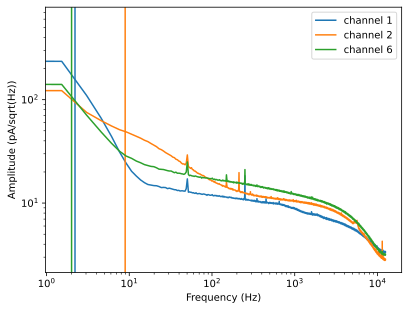

In [351]:
for i,name in enumerate(names):
    plt.loglog(nps[name][:,0], 
               1e6*np.sqrt(nps[name][:,1]), label=f'channel {channels[name]}')
    gf = 1/(2*np.pi*tau_slow[name])
    plt.axvline(gf, color='C'+str(i))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (pA/sqrt(Hz))')
plt.show()

In [352]:
nps[name][500, 0]

762.9394531249999

In [353]:
def noise_template(freq, tes_fluct_, p0_, p1_, p2_, ex_phonon_, ex_jf_, excess_): 
    
    js_noise = js_pref[name] * ex_jf_ ** 2 * np.abs(s22_int[name])**2
    s_noise = (1.2) ** 2 * np.ones(freq.shape) * 1e-12 * h
    j_noise = jf_pref[name] * np.abs(s22_ext[name])**2 
    print(nps[name][500,1], js_noise[500], np.sqrt(nps[name][500,1]/js_noise[500]))
    t_noise = thermal_pref[name] * ex_phonon_ ** 2 * np.abs(s21_int[name])**2 
    print(nps[name][25,1], t_noise[25] + j_noise[25], np.sqrt(nps[name][25,1]/(t_noise[25] + j_noise[25])))
    flicker = 1 / np.maximum(freq,1) ** (power[name]) * I_f[name] ** 2 * R_op[name] ** 2 * np.abs(s22_ext[name])**2
    flicker = (1e-4 * tes_fluct[name]) ** 2 * flicker * h
    print(nps[name][1,1], flicker[1], np.sqrt(nps[name][1,1]/flicker[1]))
    p0_norm = nps[name][33,1]/power_component[33] * power_component /np.abs(s22_int[name][33])**2
    p1_norm = nps[name][98,1]/power_component_two[98] * power_component_two /np.abs(s22_int[name][98])**2
    p2_norm = nps[name][164,1]/power_component_three[164] * power_component_three /np.abs(s22_int[name][164])**2
    em_noise = (p0_ ** 2 * p0_norm + p1_ ** 2 * p1_norm + p2_ ** 2 * p2_norm) * np.abs(s22_int[name])**2
    
    excess_events = excess_ ** 2 * (slow_pulse_nps[name] + fast_pulse_nps[name]) * h
    # print(nps[name][25,1], excess_events[25], np.sqrt(nps[name][25,1]/excess_events[25]))
    
    noise = js_noise + s_noise + t_noise + j_noise + flicker + em_noise + excess_events
    return noise

In [354]:
from scipy.optimize import minimize

def neglnlike(params, x, y):
    model = noise_template(x, *params)
    output = np.sum(np.log(model) + y/model)
    if not np.isfinite(output):
        return 1.0e30
    return output

In [357]:
tes_fluct = {'li1p': 2.5,#5.,#7.6,
             'li1l': 5.,#10,#15.1, 
             'li2p': .37,#0.75,#1.15,
            }
power = {'li1p': 2.5,
         'li1l': 1.5, 
         'li2p': 2.,}
p0 = {'li1p': 1., 'li1l': 1., 'li2p': 1.,}
p1 = {'li1p': 1., 'li1l': 1., 'li2p': 1.,}
p2 = {'li1p': 1., 'li1l': 1., 'li2p': 1.,}
ex_phonon = {'li1p': 1.,#3.,#5.,#5.
             'li1l': 1.,#5.,#8.,#8. 
             'li2p': 1.,#4.,#8.,#8.
            }
ex_jf = {'li1p': 3.5,#7.,#10.6,#10.6 
         'li1l': 4.31,#8.6,#13.2,#13.2 
         'li2p': 4.25,#8.5,#13.,#13.
        }
excess = {'li1p': 0.,#10.6 
         'li1l': 0.,#13.2 
         'li2p': 0.,#13.
}

s21_int = {}
s21_ext = {}
s22_ext = {}
s22_int = {}

thermal_pref = {}
jf_pref = {}
js_pref = {}

minis_noise = {}
noise_pars = {}
noise_std = {}

lowpass = {'li1p': 3.5e3, 'li1l': 3.5e3, 'li2p': 3.5e3,}

fit = False

for name in names:
    
    power_ts = np.sin(2 * np.pi * utils_par['t'] * 50)
    power_component = np.abs(np.fft.rfft(power_ts)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA_op ** 2

    power_ts_two = np.sin(2 * np.pi * utils_par['t'] * 150)
    power_component_two = np.abs(np.fft.rfft(power_ts_two)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA_op ** 2

    power_ts_three = np.sin(2 * np.pi * utils_par['t'] * 250)
    power_component_three = np.abs(np.fft.rfft(power_ts_three)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA_op ** 2

    b, a = butter(N=1, Wn=lowpass[name], btype='lowpass', analog=True)
    _, h = freqs(b, a, worN=utils_par['freq'])

    h = np.abs(h) ** 2
    
    I_f0 = I_f[name]
    R_f0 = R_op[name]
    R_s = utils_par['Rs']
    L = utils_par['L']
    tau = Ce[name] / thermal_link[name]
    tau_el = utils_par['L'] / (R_f0 + R_s)
    L_I = I_f0 ** 2 / thermal_link[name] * dRdT_op[name]  # loop gain
    w = utils_par['freq']
    tau_I = tau / (1 - L_I)

    # for thermal noise
    s21_int[name] = -1 / (I_f0 * R_f0) 
    denom = L / (tau_el * R_f0 * L_I)
    denom += (1 + R_s / R_f0)  # here the sign other than in Irwin
    denom += 2 * np.pi * 1j * w * L * tau / (R_f0 * L_I) * (1 / tau + 1 / tau_el) 
    denom -= (4 * np.pi**2 * w**2 * tau * L) / L_I / R_f0
    s21_int[name] /= denom 

    # for TES johnson and flicker
    s21_ext[name] = -1 / (I_f0 * R_f0) 
    denom = L * tau / (tau_el * tau_I * R_f0 * L_I) + 2 
    denom += 2 * np.pi * 1j * w * L * tau / (R_f0 * L_I) * (1 / tau_I + 1 / tau_el)
    denom -=  (4 * np.pi**2 * w**2 * tau) / L_I * L / R_f0
    s21_ext[name] /= denom
    s22_ext[name] = s21_ext[name] * I_f0 * (L_I - 1) / L_I * (1 + 2 * np.pi * 1j * w * tau_I)

    # for shunt johnson noise and emi 
    s22_int[name] = -s21_int[name] * I_f0 * (1 / L_I) * (1 + 2 * np.pi * 1j * w * tau)    
    
    thermal_pref[name] = 4 * kB * T_op[name]**2 * G_eff[name] * 2/5 * (1 - (utils_par['T_bath']/T_op[name])**5) / (1 - (utils_par['T_bath']/T_op[name])**2) * 1e3 * h
    jf_pref[name] = 4 * kB * T_op[name] * R_op[name] * 1e3 * h
    js_pref[name] = 4 * kB * utils_par['T_bath'] * utils_par['Rs'] * 1e3 * h
    
    if fit:

        res = minimize(neglnlike, [tes_fluct[name], p0[name], p1[name], p2[name], ex_phonon[name], ex_jf[name]], 
                       args=(nps[name][:,0], nps[name][:,1]), method='Nelder-Mead', tol=1e-16)

        noise_pars[name] = res.x

        tes_fluct[name] = noise_pars[name][0]
        p0[name] = noise_pars[name][1]
        p1[name] = noise_pars[name][2]
        p2[name] = noise_pars[name][3]
        ex_phonon[name] = noise_pars[name][4]
        ex_jf[name] = noise_pars[name][5]

8.937342356445177e-11 3.543083457324622e-11 1.5882304058304693
1.7495142018808388e-10 6.286152498207521e-11 1.6682697687182346
5.516768383976949e-08 6.065889236777091e-08 0.9536634484997886


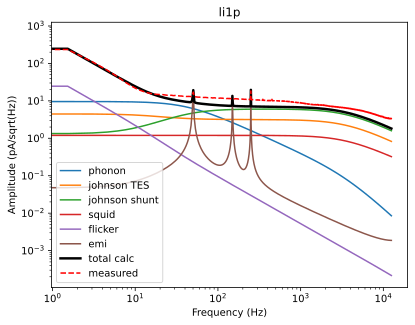

1.1600921931075434e-10 9.751214148779755e-11 1.0907291125508112
6.892408626182613e-10 2.335345956337214e-10 1.7179475317012123
1.494808759230631e-08 4.2703774096297567e-10 5.916429413769811


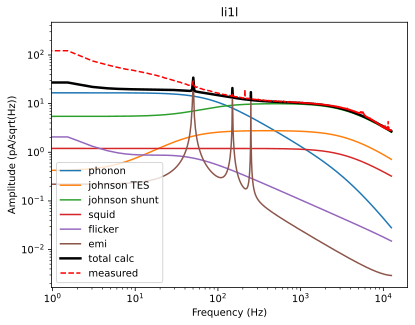

1.6330019060486513e-10 1.075303976093348e-10 1.2323319830384383
3.7781063873872303e-10 9.432939327605231e-11 2.00130633899533
1.9714698351300825e-08 3.975520530398557e-08 0.7042033195001612


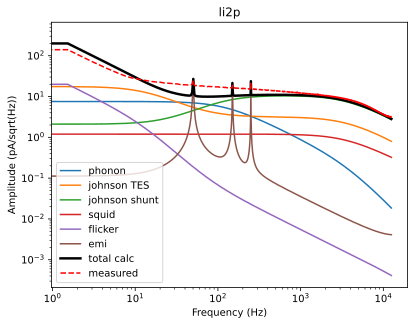

In [358]:
details = True

for name in names:
    
    freq = utils_par['freq']
    tes_fluct_ = tes_fluct[name]
    power_ = power[name]
    p0_ = p0[name]
    p1_ = p1[name]
    p2_ = p2[name]
    ex_phonon_ = ex_phonon[name]
    ex_jf_ = ex_jf[name]
    excess_ = excess[name]
    
    if details:
    
        js_noise = js_pref[name] * ex_jf_ ** 2 * np.abs(s22_int[name])**2
        s_noise = 1.2 ** 2 * np.ones(freq.shape) * 1e-12 * h
        t_noise = thermal_pref[name] * ex_phonon_ ** 2 * np.abs(s21_int[name])**2
        j_noise = jf_pref[name] * np.abs(s22_ext[name])**2
        flicker = 1 / np.maximum(freq,1) ** (power[name]) * I_f[name] ** 2 * R_op[name] ** 2 * np.abs(s22_ext[name])**2
        flicker = (1e-5 * tes_fluct[name]) ** 2 * flicker
        p0_norm = nps[name][33,1]/power_component[33] * power_component /np.abs(s22_int[name][33])**2
        p1_norm = nps[name][98,1]/power_component_two[98] * power_component_two /np.abs(s22_int[name][98])**2
        p2_norm = nps[name][164,1]/power_component_three[164] * power_component_three /np.abs(s22_int[name][164])**2
        em_noise = (p0_ ** 2 * p0_norm + p1_ ** 2 * p1_norm + p2_ ** 2 * p2_norm) * np.abs(s22_int[name])**2
        
        # excess_events = excess[name] ** 2 * (slow_pulse_nps[name] + fast_pulse_nps[name]) * h
    
        plt.plot(utils_par['freq'], np.sqrt(t_noise)*1e6, label='phonon')
        plt.plot(utils_par['freq'], np.sqrt(j_noise)*1e6, label='johnson TES')
        plt.plot(utils_par['freq'], np.sqrt(js_noise)*1e6, label='johnson shunt')
        plt.plot(utils_par['freq'], np.sqrt(s_noise)*1e6, label='squid')
        plt.plot(utils_par['freq'], np.sqrt(flicker)*1e6, label='flicker')
        plt.plot(utils_par['freq'], np.sqrt(em_noise)*1e6, label='emi')
        # plt.plot(utils_par['freq'], np.sqrt(excess_events)*1e6, label='excess')
        
    noise_calc = noise_template(freq, tes_fluct_, p0_, p1_, p2_, ex_phonon_, ex_jf_, excess_)
    noise_meas = nps[name][:,1]

    plt.plot(utils_par['freq'], np.sqrt(noise_calc)*1e6, color='black', linewidth=2.5, label='total calc')
    plt.plot(nps[name][:,0], np.sqrt(noise_meas)*1e6, label='measured', color='red', linewidth=1.5, linestyle='dashed')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(name)
    plt.ylabel('Amplitude (pA/sqrt(Hz))')
    plt.xlabel('Frequency (Hz)')
    plt.show()
    

In [379]:
tpa_height = {'li1p': 0.2, 'li1l': 0.32, 'li2p': 0.32, }

In [404]:
pars = {}

for name in names:

    pars[name] = {
        'C': np.array([Ce[name], Cph[name]]),  # pJ / mK, is defined later bec mutable
        'Gb': np.array([thermal_link[name], absorber_bath[name]]),  # pW / mK
        'G': np.array([[0., eph_coupling[name]], [eph_coupling[name], 0.], ]),  # heat cond between components, pW / mK
        'lamb': np.array([tau_rise[name], tau_rise[name]]),  # thermalization time (s)
        'lamb_tp': np.array([0.00298 if name == 'li1l' else 0.00497]),
        'eps': np.array([[epsilon[name], 1 - epsilon[name]], [epsilon[name], 1 - epsilon[name]], ]),  # share thermalization in components
        'Rs': np.array([utils_par['Rs']]),  # Ohm
        'Rh': np.array([heater_resistance[name]]),  # Ohm
        'L': np.array([utils_par['L']]),  # H
        'Rt0': np.array([tes_rt0[name]]),  # Ohm
        'k': np.array([4*dRdT_op[name]/tes_rt0[name]]),  # 1/mK
        'Tc': np.array([T_op[name]]),  # mK
        'Ib': np.array([bias[name]]),  # muA
        'dac': np.array([open_loop_out[name]]),  # V
        'pulser_scale': np.array([pulser_amplitude[name]]),  # scale factor
        'heater_current': np.array([heater_current[name]]),  # TODO should be different
        'eta': np.array([1/v_to_muA_op]),
        'tes_flag': np.array([True, False], dtype=bool),  # which component is a tes
        'heater_flag': np.array([False, True], dtype=bool),  # which component has a heater
        'i_sq': np.array([1.2]),  # squid noise, A / sqrt(Hz) 
        'tes_fluct': np.array([1e-4]),  # ??  # TODO fix units
        'flicker_slope': np.array([2.]),
        'emi': np.array([[1.5e-5, 1.5e-5, 1.5e-5]]),  # ??  # TODO fix units and only the peaks
        # 'Tb': lambda t: utils_par['T_bath'],  # function that takes one positional argument t, returns Tb
        'tau_cap': np.array([1]),
        'Ib_range': (0., 17.86),
        'excess_johnson': np.array([1]),
        'R_op_target': R_op[name],
        'tau_eff': tau_fast[name],
        'tau_t': tau_slow[name],
        'nps': nps[name],
        'sev': sev[name],
        'sev_tp': sev_tp[name],
        'tpa_height' : tpa_height[name],
        'dRdT_op': dRdT_op[name],   
        'transition_curve': transition_curves[name],
        'Afast': Afast[name],
        'Aslow': Aslow[name],
        'Vph_iron': Vph_iron[name],
        'R_iron': R_iron[name],
        'V_op': V_op[name],
        'Tph_iron': Tph_iron[name],
    }


In [405]:
import pickle

for name in names:

    fname = 'saved_pars/{}_pars.pkl'.format(name)
    with open(fname, 'wb') as fh:
        pickle.dump(pars[name], fh)
        print('dictionary saved successfully to file {}'.format(fname))

dictionary saved successfully to file saved_pars/li1p_pars.pkl
dictionary saved successfully to file saved_pars/li1l_pars.pkl
dictionary saved successfully to file saved_pars/li2p_pars.pkl
